<a href="https://colab.research.google.com/github/aaryyang/XAI-submission/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas scikit-learn tensorflow keras shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=30d20d409c267256959431567a9a22caf895c3a5123adb11fc66de3b073e29a5
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
# 0) Imports & configuration
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib


# Make plots look ok in notebooks
plt.rcParams.update({"figure.figsize": (12, 5), "grid.alpha": 0.3})


# Paths
DATA_PATH = "/content/nifty.csv"
OUT_DIR = "/mnt/data/lstm_refactor_outputs"
os.makedirs(OUT_DIR, exist_ok=True)


# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# 1) Parameters
TIME_STEPS = 60
TEST_SIZE = 0.2
LSTM_UNITS = 60
DROPOUT = 0.3
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001


FEATURE_COLUMNS = ["Open", "High", "Low", "%Chg"]
TARGET_COLUMN = "Price"

In [ ]:
# 2) Load & initial cleaning
print("Loading data from:", DATA_PATH)
df = pd.read_csv(DATA_PATH)

if "Date" in df.columns:
    date_col = "Date"
elif "date" in df.columns:
    date_col = "date"
else:

    date_col = df.columns[0]



try:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
except Exception:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")



df = df.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)



required = FEATURE_COLUMNS + [TARGET_COLUMN]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")



dates = df[date_col].reset_index(drop=True)



for c in required:
    df[c] = pd.to_numeric(df[c], errors="coerce")



df = df.dropna(subset=required).reset_index(drop=True)


print(f"Dataset contains {len(df)} rows after cleaning")

Loading data from: /content/nifty.csv
Dataset contains 4999 rows after cleaning


In [ ]:
# Helper to create indices for time-series sequences
def make_sequences_indices(data_len, time_steps):
    """Creates indices for sequences and their corresponding target."""
    indices = []
    for i in range(data_len - time_steps):
        indices.append((i, i + time_steps))
    return indices

X_raw = df[FEATURE_COLUMNS].values
y_raw = df[[TARGET_COLUMN]].values

idxs = make_sequences_indices(len(X_raw), TIME_STEPS)
print(f"Total sequences available: {len(idxs)}")


split_at = int(len(idxs) * (1 - TEST_SIZE))
train_idxs = idxs[:split_at]
test_idxs = idxs[split_at:]


def build_Xy_from_indices(X, y, idx_list, time_steps):
    Xs = np.zeros((len(idx_list), time_steps, X.shape[1]))
    ys = np.zeros((len(idx_list), 1))
    for i, (start, target) in enumerate(idx_list):
        Xs[i] = X[start: start + time_steps]
        ys[i] = y[target]
    return Xs, ys


X_train_raw, y_train_raw = build_Xy_from_indices(X_raw, y_raw, train_idxs, TIME_STEPS)
X_test_raw, y_test_raw = build_Xy_from_indices(X_raw, y_raw, test_idxs, TIME_STEPS)


print("Shapes -> X_train, y_train, X_test, y_test:", X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape)


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()


n_train_seq = X_train_raw.shape[0]
scaler_X.fit(X_train_raw.reshape(-1, X_train_raw.shape[2]))
scaler_y.fit(y_train_raw)


X_train = scaler_X.transform(X_train_raw.reshape(-1, X_train_raw.shape[2])).reshape(X_train_raw.shape)
X_test = scaler_X.transform(X_test_raw.reshape(-1, X_test_raw.shape[2])).reshape(X_test_raw.shape)


y_train = scaler_y.transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw)


dates_test = []
for _, target in test_idxs:
    dates_test.append(dates.iloc[target])

dates_test = pd.to_datetime(pd.Series(dates_test)).reset_index(drop=True)

Total sequences available: 4939
Shapes -> X_train, y_train, X_test, y_test: (3951, 60, 4) (3951, 1) (988, 60, 4) (988, 1)


In [ ]:
# 4) Model build & train
print("Building LSTM model...")
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    tf.random.set_seed(RANDOM_SEED)

    model = Sequential([
        LSTM(LSTM_UNITS, return_sequences=True, input_shape=(TIME_STEPS, X_train.shape[2])),
        Dropout(DROPOUT),
        LSTM(LSTM_UNITS, return_sequences=False),
        Dropout(DROPOUT),
        Dense(max(16, LSTM_UNITS // 2), activation='linear'),
        Dense(1, activation='linear')
    ])

    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    print(model.summary())

    callbacks = []

    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=callbacks,
        verbose=1
    )

    lstm_used = True
except Exception as e:
    print("TensorFlow unavailable or failed to run. Falling back to naive baseline. Error:", e)
    lstm_used = False
    model = None

Building LSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 60)         │        15,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,501 (181.64 KB)

 Trainable params: 46,501 (181.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0278 - val_loss: 8.5542e-04
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 7.4909e-04
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 8.4210e-04
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 0.0042
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 8.1730e-04
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 6.8687e-04
Epoch 9/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 6.5723e-04
Epoch 10/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 8.7214e-04
Epoch 11/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.7444e-04 - val_loss: 7.1903e-04
Epoch 12/30
56/56 ━━━━━━━━━━━━

In [ ]:
# 5) Predict & evaluate
if lstm_used:
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)
else:
    all_idxs = make_sequences_indices(len(X_raw), TIME_STEPS)
    y_all = []
    for _, target in all_idxs:
        y_all.append(y_raw[target][0])
    y_all = np.array(y_all).reshape(-1, 1)


    y_true = y_all[split_at:]
    y_pred = np.roll(y_all, 1, axis=0)[split_at:]
    y_pred[0] = y_true[0]


rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
mae = float(mean_absolute_error(y_true, y_pred))
r2 = float(r2_score(y_true, y_pred))


print("--- Evaluation on Test Set ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R^2 : {r2:.4f}")


metrics = {"RMSE": rmse, "MAE": mae, "R2": r2, "LSTM_used": lstm_used}
with open(os.path.join(OUT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)


pd.DataFrame([metrics]).to_csv(os.path.join(OUT_DIR, "metrics.csv"), index=False)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
--- Evaluation on Test Set ---
RMSE: 267.9036
MAE : 219.8359
R^2 : 0.9558


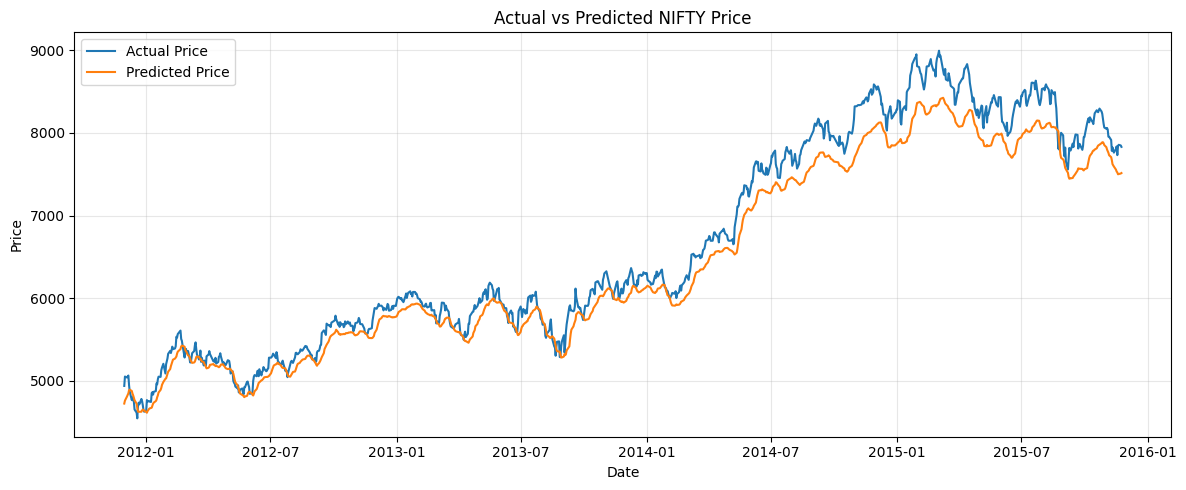

In [ ]:
# 6) Plot Actual vs Predicted
plt.figure()
plt.plot(dates_test, y_true, label='Actual Price')
plt.plot(dates_test, y_pred, label='Predicted Price')
plt.title('Actual vs Predicted NIFTY Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 7) Explainability (LIME & SHAP)
explainability_info = {"lstm_used": lstm_used, "lime_ran": False, "shap_ran": False}


# LIME: Explainer for timeseries (example using first test instance)
try:
    import lime
    from lime import lime_tabular
    explainability_info['lime_available'] = True
    if lstm_used:
        lime_background_data = X_train[:, -1, :]
        def predict_lime(x_tab):
            m = x_tab.shape[0]
            seqs = np.zeros((m, TIME_STEPS, X_test.shape[2]))
            reference = X_test[0, :-1, :]
            for i in range(m):
                seqs[i, :-1, :] = reference
                seqs[i, -1, :] = x_tab[i]
            preds = model.predict(seqs)
            return scaler_y.inverse_transform(preds).ravel()


        explainer_lime = lime_tabular.LimeTabularExplainer(
            training_data=lime_background_data,
            feature_names=FEATURE_COLUMNS,
            class_names=['Price'],
            mode='regression'
        )

        instance_to_explain = X_test[0, -1, :]


        explanation_lime = explainer_lime.explain_instance(
            data_row=instance_to_explain,
            predict_fn=predict_lime,
            num_features=len(FEATURE_COLUMNS)
        )


        print("LIME explanation computed (approx).")
        explainability_info['lime_ran'] = True
    else:
        print("LIME installed but LSTM not trained — skipping LIME explanation")

except Exception as e:
    explanation_lime = None
    explainability_info['lime_error'] = str(e)
    print("LIME not run:", e)

try:
    import shap
    explainability_info['shap_available'] = True
    if lstm_used:
        background = X_train[:50, -1, :]


        def predict_shap(x_tab):
            m = x_tab.shape[0]
            seqs = np.zeros((m, TIME_STEPS, X_test.shape[2]))
            reference = X_test[0, :-1, :]
            for i in range(m):
                seqs[i, :-1, :] = reference
                seqs[i, -1, :] = x_tab[i]
            preds = model.predict(seqs)
            return scaler_y.inverse_transform(preds).ravel()


        explainer_shap = shap.KernelExplainer(predict_shap, background)
        instance_shap = X_test[0, -1, :].reshape(1, -1)
        shap_values = explainer_shap.shap_values(instance_shap, nsamples=100)
        print("SHAP explanation computed (approx).")
        explainability_info['shap_ran'] = True
    else:
        print("SHAP installed but LSTM not trained — skipping SHAP explanation")
except Exception as e:
    explainer_shap = None
    shap_values = None
    explainability_info['shap_error'] = str(e)
    print("SHAP not run:", e)

with open(os.path.join(OUT_DIR, "explainability.json"), "w") as f:
    json.dump(explainability_info, f, indent=2)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LIME explanation computed (approx).
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
SHAP explanation computed (approx).


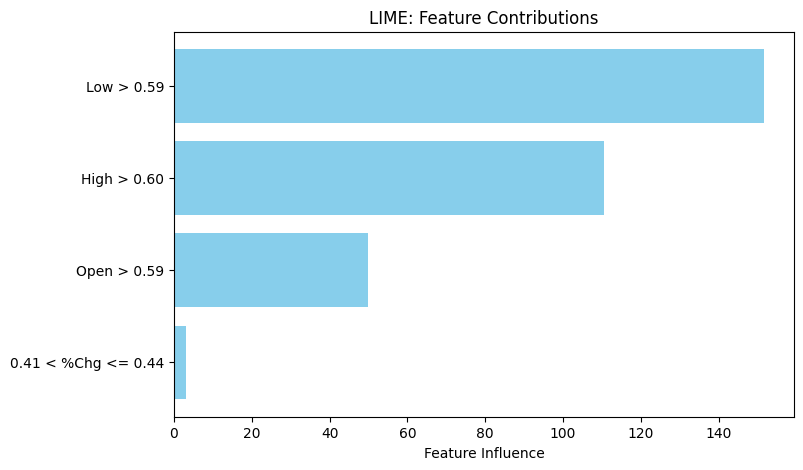

In [ ]:
import matplotlib.pyplot as plt

# --- LIME Visualization ---
if explainability_info.get("lime_ran", False) and explanation_lime is not None:
    try:
        lime_values = explanation_lime.as_list()
        lime_features, lime_importances = zip(*lime_values)
        plt.figure(figsize=(8, 5))
        plt.barh(lime_features, lime_importances, color="skyblue")
        plt.xlabel("Feature Influence")
        plt.title("LIME: Feature Contributions")
        plt.gca().invert_yaxis()
        plt.show()
    except Exception as e:
        print("LIME visualization error:", e)

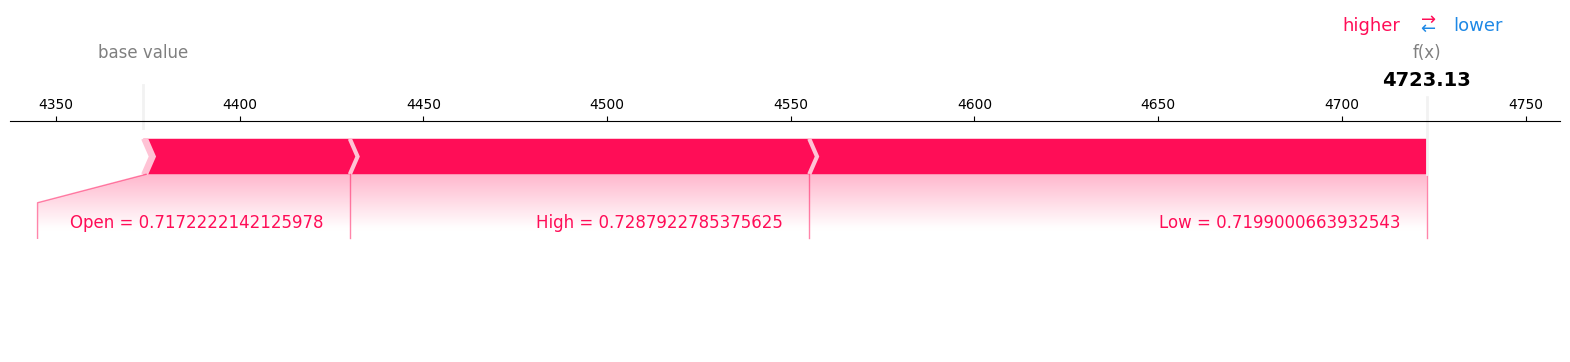

/tmp/ipython-input-3615778769.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, instance_shap, feature_names=FEATURE_COLUMNS, plot_type="bar")


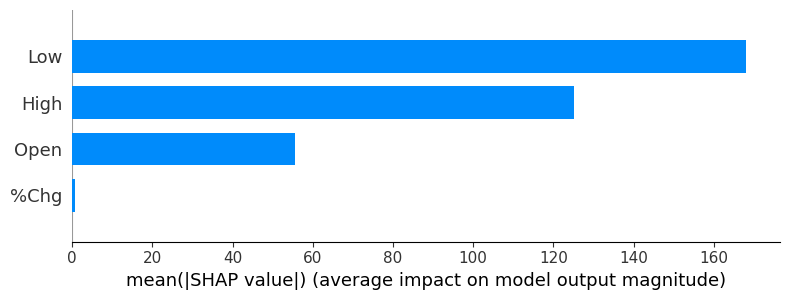

In [ ]:
# --- SHAP Visualization ---
if explainability_info.get("shap_ran", False) and shap_values is not None:
    try:
        shap.initjs()
        shap.force_plot(
            explainer_shap.expected_value,
            shap_values,
            features=instance_shap,
            feature_names=FEATURE_COLUMNS,
            matplotlib=True
        )
        plt.figure()
        shap.summary_plot(shap_values, instance_shap, feature_names=FEATURE_COLUMNS, plot_type="bar")
    except Exception as e:
        print("SHAP visualization error:", e)

In [ ]:
# 8) Display Actual vs Predicted values for the test set
if lstm_used:
    print("Actual vs Predicted values for the test set:")
    results_df = pd.DataFrame({'Actual Price': y_true.flatten(), 'Predicted Price': y_pred.flatten()}, index=dates_test)
    display(results_df)

Actual vs Predicted values for the test set:


,Actual Price,Predicted Price
2011-12-01,4936.85,4723.126953
2011-12-02,5050.15,4758.669434
2011-12-05,5039.15,4809.044922
2011-12-07,5062.60,4847.038574
2011-12-08,4943.65,4885.468750
...,...,...
2015-11-18,7731.80,7522.342285
2015-11-19,7842.75,7499.848145
2015-11-20,7856.55,7502.831543
2015-11-23,7849.25,7508.928223


In [ ]:
# 9) Save artifacts (model & scalers)
try:
    if lstm_used:
        model_path = os.path.join(OUT_DIR, "lstm_model.h5")
        model.save(model_path)
        print("Saved model to:", model_path)

        scaler_x_path = os.path.join(OUT_DIR, "scaler_X.pkl")
        scaler_y_path = os.path.join(OUT_DIR, "scaler_y.pkl")
        joblib.dump(scaler_X, scaler_x_path)
        joblib.dump(scaler_y, scaler_y_path)
        print("Saved scalers to:", scaler_x_path, scaler_y_path)
except Exception as e:
    print("Error saving artifacts:", e)

Saved model to: /mnt/data/lstm_refactor_outputs/lstm_model.h5
Saved scalers to: /mnt/data/lstm_refactor_outputs/scaler_X.pkl /mnt/data/lstm_refactor_outputs/scaler_y.pkl


In [ ]:
print("All done. Outputs are in:", OUT_DIR)
print("Files:", os.listdir(OUT_DIR))

All done. Outputs are in: /mnt/data/lstm_refactor_outputs
Files: ['explainability.json', 'lstm_model.h5', 'scaler_y.pkl', 'metrics.json', 'metrics.csv', 'scaler_X.pkl']
